全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。 因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

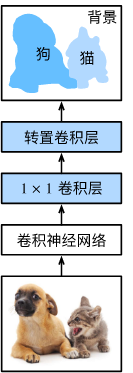

In [ ]:
%matplotlib inline
!pip install d2l
!pip install matplotlib==3.0.0
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征，并将该网络记为pretrained_net。 ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

创建一个全卷积网络net。 它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。

In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的$1/32$，即10和15。

In [ ]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。 最后，我们需要将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽。卷积层输出形状的计算方法： 由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为32的转置卷积层，并将卷积核的高和宽设为64，填充为16。 我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。

In [ ]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1)) # 1*1卷积层
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, # 转置卷积，将特征图的高困增加32倍，使得其变回输入图像的高宽
                                    kernel_size=64, padding=16, stride=32)) 

在图像处理中，我们有时需要将图像放大，即上采样（upsampling）。 双线性插值（bilinear interpolation） 是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。 首先，将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。 例如，根据输入与输出的尺寸之比来映射。 请注意，映射后的$x'$和$y'$是实数。 然后，在输入图像上找到离坐标$(x',y')$最近的4个像素。 最后，输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

In [ ]:
# 返回转置卷积层的初始参数
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5 # center = (kernel_size / 2) - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1)) # og初始化为一个元组
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。

In [ ]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置。

In [ ]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('/content/sample_data/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

可以看到，转置卷积层将图像的高和宽分别放大了2倍。 除了坐标刻度不同，双线性插值放大的图像和原图看上去没什么两样。

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


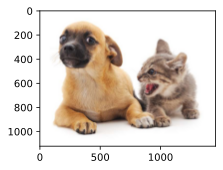

In [ ]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

在全卷积网络中，我们用双线性插值的上采样初始化转置卷积层。对于$1\times1$卷积层，我们使用Xavier初始化参数。

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [ ]:
# 读取数据集
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


 这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。 此外，模型基于每个像素的预测类别是否正确来计算准确率。

loss 0.409, train acc 0.872, test acc 0.853
78.6 examples/sec on [device(type='cuda', index=0)]


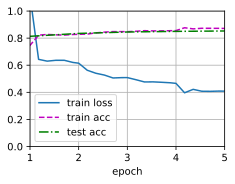

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1) # 在高宽上均做一个均值

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

在预测时，需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

为了可视化预测的类别给每个像素，将预测类别映射回它们在数据集中的标注颜色。

In [ ]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

测试数据集中的图像大小和形状各异。 由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。 为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。 请注意，这些区域的并集需要完整覆盖输入图像。 当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为softmax运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。 对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。

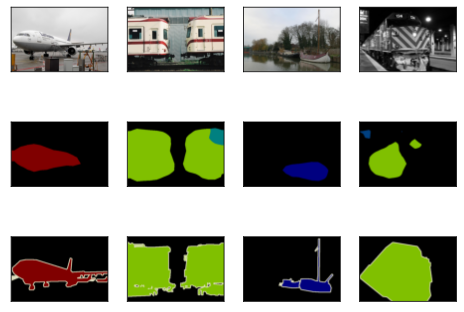

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2); # [::3]表示从头开始step=3进行切片，[1::3]表示从下标为1的元素开始step=3进行切片